<a href="https://colab.research.google.com/github/novandi18/job-recommendation-cbf-knn/blob/master/Journey_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [501]:
import pandas as pd
from datasets import load_dataset
import ast

ds = pd.read_csv("hf://datasets/lukebarousse/data_jobs/data_jobs.csv")

ds.dropna(subset=['job_skills'], inplace=True)
ds.drop(columns=['salary_rate', 'salary_year_avg', 'salary_hour_avg', 'job_no_degree_mention', 'job_health_insurance'], inplace=True)
df = ds.copy()

df['skills_one'] = df['job_skills'].apply(lambda x: ast.literal_eval(x)[0])
df['skills_two'] = df['job_skills'].apply(lambda x: ast.literal_eval(x)[1] if len(ast.literal_eval(x)) > 1 else None)

df['skills'] = df[['skills_one', 'skills_two']].apply(
    lambda row: ' '.join(row.dropna()),
    axis=1
)

df = df[df['skills'].astype(bool)].copy()
df.head()

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_country,company_name,job_skills,job_type_skills,skills_one,skills_two,skills
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14 13:18:07,Mexico,Hewlett Packard Enterprise,"['r', 'python', 'sql', 'nosql', 'power bi', 't...","{'analyst_tools': ['power bi', 'tableau'], 'pr...",r,python,r python
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10 13:14:55,Germany,ALPHA Augmented Services,"['python', 'sql', 'c#', 'azure', 'airflow', 'd...","{'analyst_tools': ['dax'], 'cloud': ['azure'],...",python,sql,python sql
3,Data Engineer,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,"San Antonio, TX",via Diversity.com,Full-time,False,"Texas, United States",2023-07-04 13:01:41,United States,Southwest Research Institute,"['python', 'c++', 'java', 'matlab', 'aws', 'te...","{'cloud': ['aws'], 'libraries': ['tensorflow',...",python,c++,python c++
4,Data Engineer,Data Engineer- Sr Jobs,"Washington, DC",via Clearance Jobs,Full-time,False,Sudan,2023-08-07 14:29:36,Sudan,Kristina Daniel,"['bash', 'python', 'oracle', 'aws', 'ansible',...","{'cloud': ['oracle', 'aws'], 'other': ['ansibl...",bash,python,bash python
5,Data Engineer,GCP Data Engineer,Anywhere,via ZipRecruiter,Contractor and Temp work,True,Georgia,2023-11-07 14:01:59,United States,smart folks inc,"['python', 'sql', 'gcp']","{'cloud': ['gcp'], 'programming': ['python', '...",python,sql,python sql


In [502]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['skills'])

feature_names = tfidf.get_feature_names_out()
for i in range(5):
    print(f"TF-IDF for vocab '{feature_names[i]}': {tfidf_matrix[0, i]:.4f}")

TF-IDF for vocab 'access': 0.0000
TF-IDF for vocab 'airflow': 0.0000
TF-IDF for vocab 'airtable': 0.0000
TF-IDF for vocab 'alteryx': 0.0000
TF-IDF for vocab 'angular': 0.0000


In [503]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump((tfidf, df), file)

In [504]:
with open('model.pkl', 'rb') as file:
    tfidf, df = pickle.load(file)

In [505]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors

param_grid = {'n_neighbors': [3, 5, 7, 9], 'metric': ['cosine', 'euclidean', 'manhattan']}

grid_search = GridSearchCV(NearestNeighbors(), param_grid, scoring='accuracy', cv=5)
grid_search.fit(tfidf_matrix)

print("Best parameters:", grid_search.best_params_)

best_knn_model = grid_search.best_estimator_
print("\nBest KNN model:", best_knn_model)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(


Best parameters: {'metric': 'cosine', 'n_neighbors': 3}

Best KNN model: NearestNeighbors(metric='cosine', n_neighbors=3)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [506]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

cbf_similarities = None
top_20_cbf_indices = None
knn_indices = None

def get_recommended_jobs(user_skills, top_n=15, knn_model=best_knn_model):
    global cbf_similarities, top_20_cbf_indices, knn_indices

    user_tfidf = tfidf.transform([' '.join(user_skills)])

    cbf_similarities = cosine_similarity(user_tfidf, tfidf.transform(df['skills'])).flatten()

    top_20_cbf_indices = cbf_similarities.argsort()[:-20 - 1:-1]
    knn_model.fit(tfidf_matrix[top_20_cbf_indices])

    _, knn_indices = knn_model.kneighbors(user_tfidf)

    top_job_indices = top_20_cbf_indices[knn_indices.flatten()]

    unique_job_indices = []
    seen_positions = set()
    for index in top_job_indices:
        position = df.iloc[index]['job_title_short']
        if position not in seen_positions:
            unique_job_indices.append(index)
            seen_positions.add(position)
            if len(unique_job_indices) == top_n:
                break

    recommended_jobs = df.iloc[unique_job_indices]['job_title_short'].tolist()

    if len(recommended_jobs) < top_n:
        recommended_skills = set(' '.join(df.iloc[unique_job_indices]['skills']).split())

        alternative_jobs_mask = df['skills'].apply(lambda x: any(skill in x for skill in recommended_skills))
        alternative_jobs = df[alternative_jobs_mask]['job_title_short'].unique().tolist()

        if len(alternative_jobs) >= top_n - len(recommended_jobs):
            recommended_jobs += alternative_jobs[:top_n - len(recommended_jobs)]
        else:
            recommended_jobs += alternative_jobs

    recommended_jobs = list(dict.fromkeys(recommended_jobs))
    return recommended_jobs[:top_n]

In [507]:
user_skills = ['python', 'mysql']
recommended_jobs = get_recommended_jobs(user_skills, top_n=15)
print(recommended_jobs)

['Data Analyst', 'Cloud Engineer', 'Data Engineer', 'Senior Data Engineer', 'Data Scientist', 'Machine Learning Engineer', 'Senior Data Analyst', 'Senior Data Scientist', 'Business Analyst', 'Software Engineer']


In [508]:
relevant_jobs = {
    'user1': ['Data Analyst', 'Data Scientist', 'Machine Learning Engineer'],
    'user2': ['Data Engineer', 'Database Administrator'],
    'user3': ['Backend Developer', 'Software Engineer'],
    'user4': ['Data Engineer', 'Backend Engineer', 'Full-Stack Engineer'],
}

def evaluate_model_hit_rate(model, users, relevant_jobs, k=10):
    hits = 0
    for user in users:
        recommended_jobs = model(user, top_n=k)
        if any(job in relevant_jobs.get(user, []) for job in recommended_jobs):
            hits += 1
    return hits / len(users)

k = 15
hit_rate = evaluate_model_hit_rate(get_recommended_jobs, relevant_jobs.keys(), relevant_jobs, k=k)
print(f"Hit Rate@{k}: {hit_rate:.2f}")

Hit Rate@15: 1.00


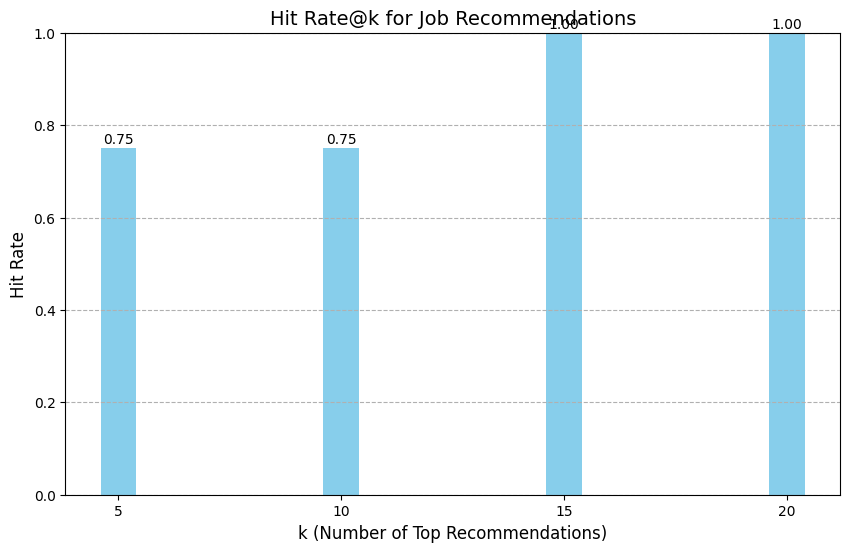

In [509]:
import matplotlib.pyplot as plt

k_values = [5, 10, 15, 20]
hit_rates = [evaluate_model_hit_rate(get_recommended_jobs, relevant_jobs.keys(), relevant_jobs, k=k) for k in k_values]

plt.figure(figsize=(10, 6))
plt.bar(k_values, hit_rates, color='skyblue')
plt.xlabel('k (Number of Top Recommendations)', fontsize=12)
plt.ylabel('Hit Rate', fontsize=12)
plt.title('Hit Rate@k for Job Recommendations', fontsize=14)
plt.xticks(k_values)
plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--')
for i, v in enumerate(hit_rates):
    plt.text(k_values[i], v + 0.01, f'{v:.2f}', ha='center')
plt.show()

In [510]:
from sklearn.metrics import average_precision_score

def evaluate_model_map(model, users, relevant_jobs, k=15):
    average_precisions = []
    for user in users:
        recommended_jobs = model(user, top_n=k)
        recommended_indices = [df[df['job_title_short'] == job].index[0] for job in recommended_jobs]

        y_true = [1 if df.iloc[i]['job_title_short'] in relevant_jobs.get(user, []) else 0 for i in recommended_indices]

        cbf_scores = cbf_similarities[recommended_indices]

        if sum(y_true) > 0:  # Hanya hitung jika ada relevan items
            average_precisions.append(average_precision_score(y_true, cbf_scores))

    if average_precisions:  # Hindari pembagian dengan nol
        return sum(average_precisions) / len(average_precisions)
    else:
        return 0

k = 15
map_scores = evaluate_model_map(get_recommended_jobs, relevant_jobs.keys(), relevant_jobs, k=k)
print(f"Mean Average Precision@{k}: {map_scores:.2f}")

Mean Average Precision@15: 0.50


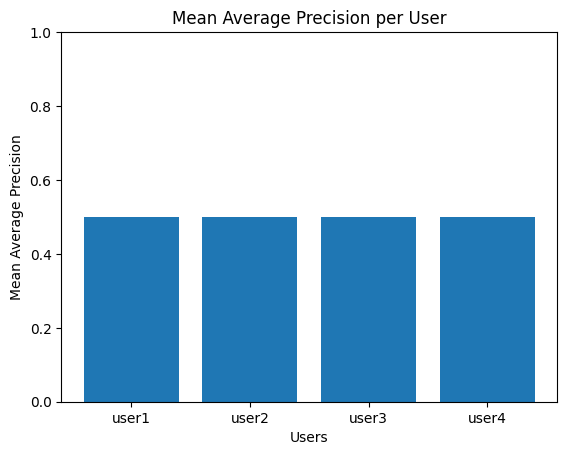

In [511]:
plt.bar(relevant_jobs.keys(), map_scores)
plt.xlabel('Users')
plt.ylabel('Mean Average Precision')
plt.title('Mean Average Precision per User')
plt.ylim(0, 1)
plt.show()